# Module 2 Project - KC Housing Price Regression

# Scope and Business Understanding
I will be building a multivariate regression on the KC Housing Dataset with the goal of predicting house sale price as accurately as possible. This exercise will be completed in the context of a private equity / real estate investment firm looking for diligence and valuation support. Ideally, this regression will help identify statistically significant variables to target during due diligence processes to ensure time is spent researching aspects of a house that are meaningful to price. Additionally, if the data supports it, firms will be able to leverage this data to determine which potential future projects might be correlated with higher sales prices to guide renovation work. Ultimately, using the tool for buyers and sellers, this tool can be used to minimize risk and help improve return realization. 

I will aim to answer the following three primary questions:
1. What does the current KC housing market look like and what do the majority of houses have in common
2. Are there specific times (years, months, days) that might be related with a higher sale price?
3. Are provided rankings (grade, condition, etc.) trustworthy and are they actually relevant to predicting sale price?

# Data Understanding

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
%matplotlib inline

In [2]:
# set style of graphs and visualizations
plt.style.use('ggplot')

In [3]:
# import raw dataset
raw_df = pd.read_csv('kc_house_data.csv')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

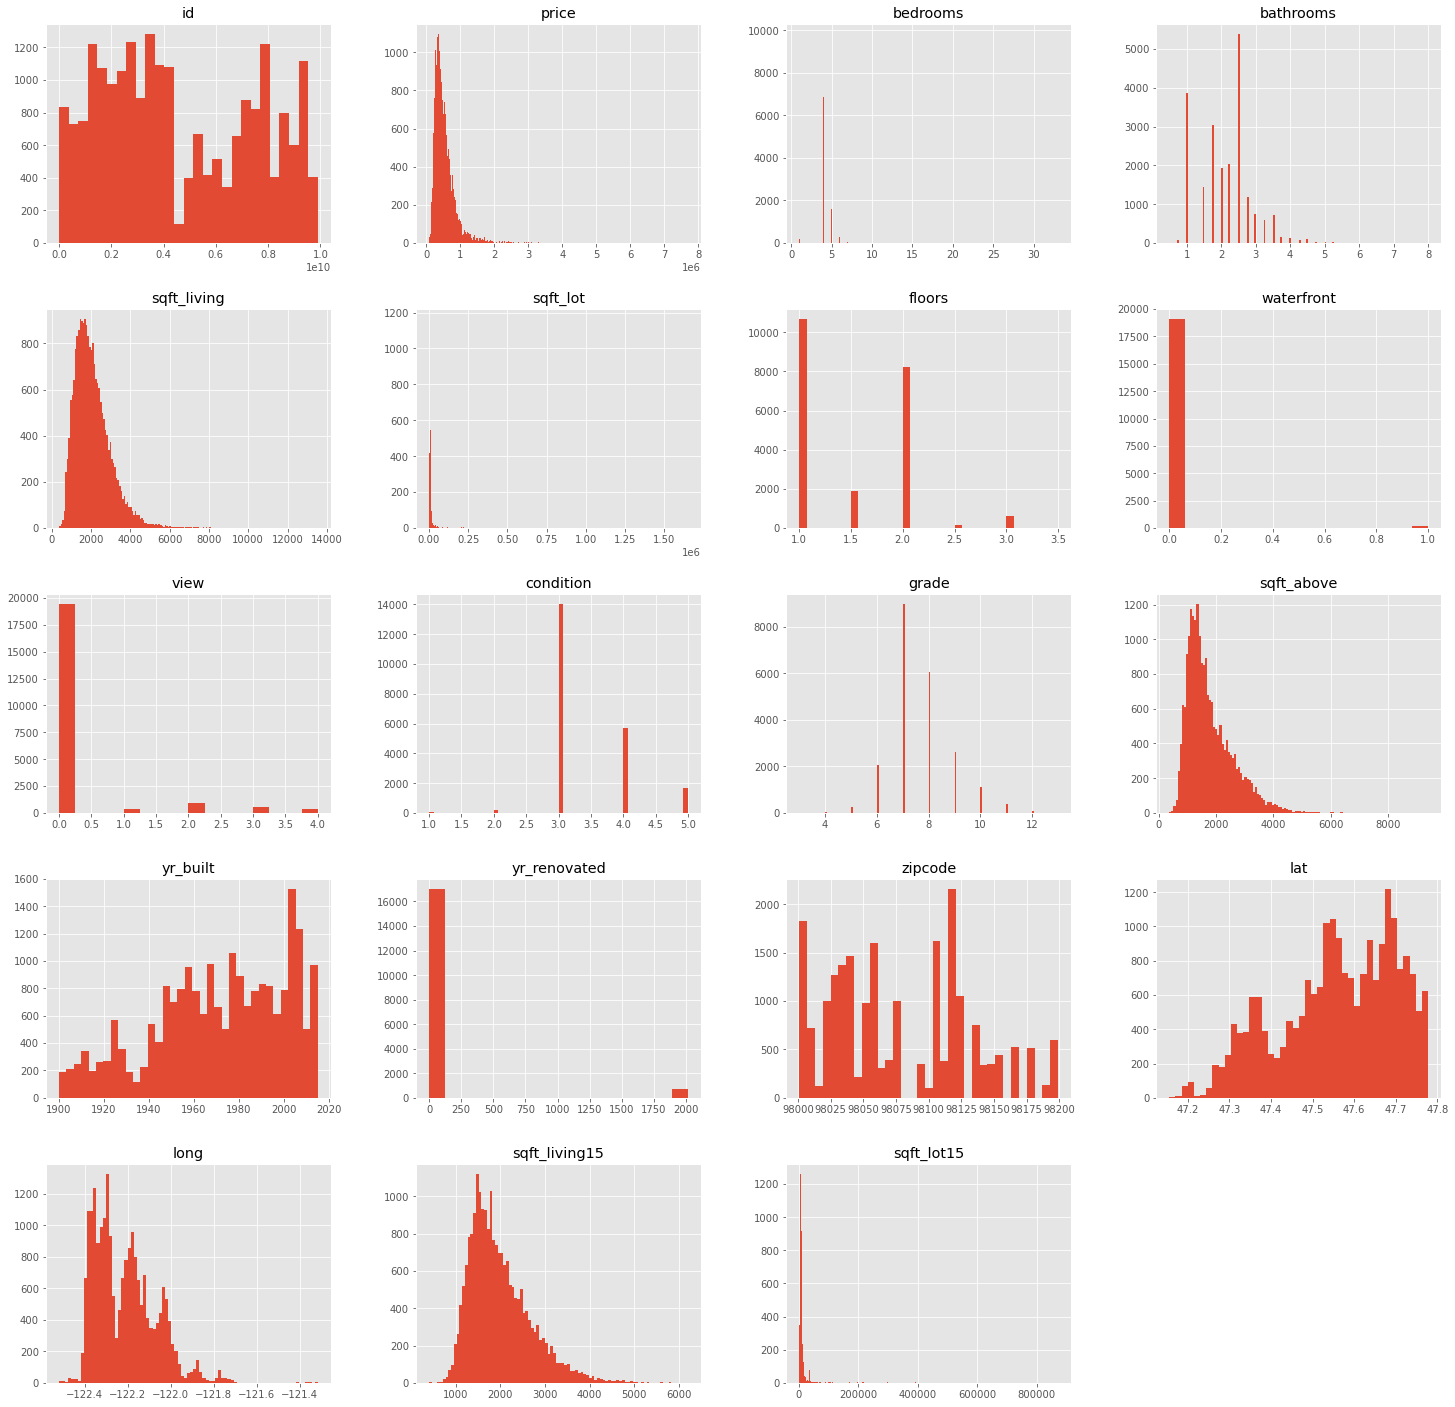

In [4]:
# explore distribution of data - plot histograms of each variable
raw_df.hist(figsize=(25, 25), bins='auto')
plt.show()

In [5]:
# produce summary statistics
raw_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


 - bathrooms: appears to be categorical with the majority of entries falling between 0.5 and 3 bathrooms. there are a number of outliers to the right, with one entry having 8 bedrooms.  Room to clean these outliers up after the baseline model is generated.  Summary stats presented above, shows a median of 2.25 bathrooms, and a standard deviation of just over 0.75 bathrooms
 - bedrooms: appears to be categorical with the majority of entries having 1 to 4 bedrooms.  Significant oulier with one entry having 33 bedrooms.  Median number of bedrooms is 3, with a standard deviation of just under 1 bedroom
 - condition: appears categorical, max of 5, median of 3 - - looks like the majority are condition ratings of 3 and 4.  standard deviation of 0.65 (just over half one condition rating)
 - day_sold: appears to be categorical.  Looks like there is no deviation other than near the beginning of the month (day 1) and the middle of the month (day ~20) showing more houses sold near these days than on others
 - floors: categorical with a significant falloff after 2 floors
 - grade: appears somewhat normally distributed although it is categorical.  Some grades above 10, with the most between 6 and 9.  Median grade is 7 with a std of 1.17
 - month_sold: categorical, but interesting to see that there are more houses sold during the summer months than winter months, which makes sense
 - price, sqft_above, sqft_living, sqft_living15 appear log normally distributed, with right skew and likely some positive outliers
 - sqft_lot and sqft_lot15 have have significant right skew and outliers
 - view: very few houses have been viewed (> 0 value)
 - waterfront: very few houses have waterfront
 - year_sold: only two years of sale data is included here (2014 and 2015), with more entries coming from 2014 than 2015
 - yr_built: the majority of houses represented were built after 1950, with the earliest house included being built in 1900
 - yr_renovated: only a handful have received renovations

In [6]:
# print data types of each column
for col in raw_df.columns:
    print(f'{col}-{raw_df[col].dtype}')

id-int64
date-object
price-float64
bedrooms-int64
bathrooms-float64
sqft_living-int64
sqft_lot-int64
floors-float64
waterfront-float64
view-float64
condition-int64
grade-int64
sqft_above-int64
sqft_basement-object
yr_built-int64
yr_renovated-float64
zipcode-int64
lat-float64
long-float64
sqft_living15-int64
sqft_lot15-int64


`sqft_basement` and `date` are the only two columns that are non-numerical, will need to be handled during data preparation. 

# Data Preparation

In [7]:
# start by dropping id column as this will not help with predicting price
clean_df = raw_df.drop('id', axis=1)

In [8]:
# check for missing values
clean_df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

We can see we are missing values in three columns - waterfront, yr_renovated, and view, with far more missing out of waterfront and yr_renovated.

In [9]:
# calc percentage of data missing
waterfront_missing = round(clean_df['waterfront'].isna().sum() / len(clean_df), 4)
yr_renovated_missing = round(clean_df['yr_renovated'].isna().sum() / len(clean_df), 4)
view_missing = round(clean_df['view'].isna().sum() / len(clean_df), 4)

# print percentages
print(f'Missing waterfront values comprise {waterfront_missing * 100}% of total data')
print(f'Missing yr_renovated values comprise {yr_renovated_missing * 100}% of total data')
print(f'Missing view values comprise {view_missing * 100}% of total data')

Missing waterfront values comprise 11.0% of total data
Missing yr_renovated values comprise 17.79% of total data
Missing view values comprise 0.29% of total data


In [10]:
# explore other values in these columns
print('waterfront')
display(clean_df['waterfront'].unique())
print('yr_renovated')
display(clean_df['yr_renovated'].unique())
print('view')
display(clean_df['view'].unique())

waterfront


array([nan,  0.,  1.])

yr_renovated


array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

view


array([ 0., nan,  3.,  4.,  2.,  1.])

Looking at the value distribution for the three columns with missing values, can see the following:
* waterfront: only two other values, either 0 or 1. Missing values are likely instances where waterfront=0
* yr_renovated: 0 values refer to non-renovated houses.  Missing values are likely the same
* view: 5 other classes of view

Given these observations, the missing values will be handled in the following manner:
* waterfront: NaNs assigned value of 0
* yr_renovated: NaNs assigned value of 0
* view: NaNs assigned value of column median

In [11]:
# handle missing values
clean_df['waterfront'] = clean_df['waterfront'].fillna(value=0.)
clean_df['yr_renovated'] = clean_df['yr_renovated'].fillna(value=0.)
clean_df['view'] = clean_df['view'].fillna(value=clean_df['view'].median())

In [12]:
# check for duplicates
clean_df.duplicated().sum()

0

We have handled missing values and there are no duplicated entries.  Will move on to checking column types.

In [13]:
# handle non-numeric typed columns
clean_df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2350.0        1
2190.0        1
2180.0        1
176.0         1
225.0         1
Name: sqft_basement, Length: 304, dtype: int64

We can see there are some entries with a `sqft_basement` value of `?`. Given there are only 454 of these, drop them from the dataset. 

In [14]:
# drop ? values from sqft_basement
clean_df = clean_df.loc[clean_df['sqft_basement'] != '?']

# convert back to number format
clean_df['sqft_basement'] = clean_df['sqft_basement'].astype('float')

In [15]:
# convert date column to datetime and then split into year, month, day
clean_df['date'] = pd.to_datetime(clean_df['date'], infer_datetime_format=True)
clean_df['year'] = clean_df['date'].map(lambda x: x.year)
clean_df['month'] = clean_df['date'].map(lambda x: x.month)
clean_df['day'] = clean_df['date'].map(lambda x: x.day)

# drop initial date column
clean_df = clean_df.drop('date', axis=1)

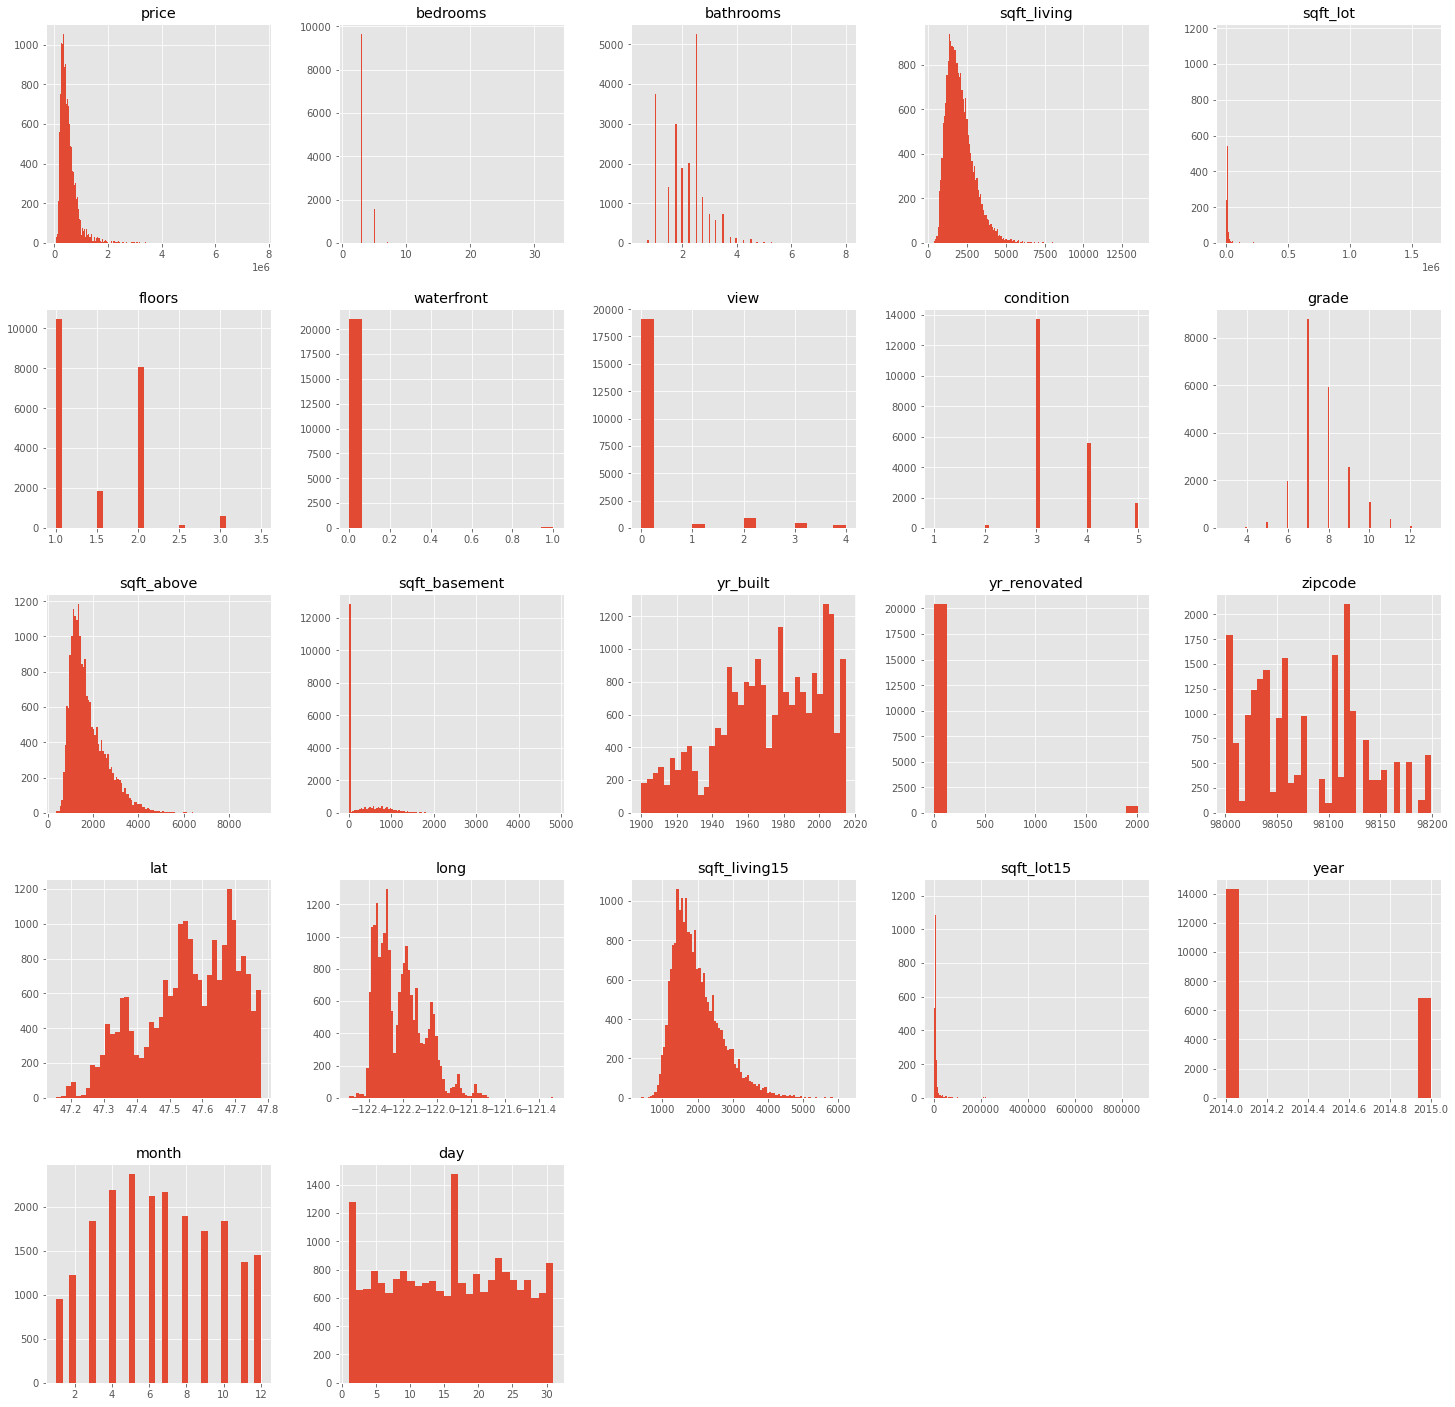

In [16]:
# reprint histograms of each column
clean_df.hist(figsize=(25, 25), bins='auto')
plt.show()

In [17]:
def plot_viz(data, target, predictors, nrows=1, ncols=1, figsize=(10, 4)):
    """
    Function to plot y vs. a chosen set of x variables: includes regression line
    Parameters:
        data: name of dataframe variables are coming from
        target: string of target variable
        predictors: dataframe of predictors
        nrows: number of rows of subplots
        ncols: number of cols of subplots
        figsize: size of the figure
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for ax, feature in zip(axes.flatten(), predictors):
        sns.regplot(x=feature, y=target, data=data, ax=ax, scatter_kws={'alpha':0.2});
        ax.set_title(f'{feature} vs. {target}')
    plt.tight_layout()

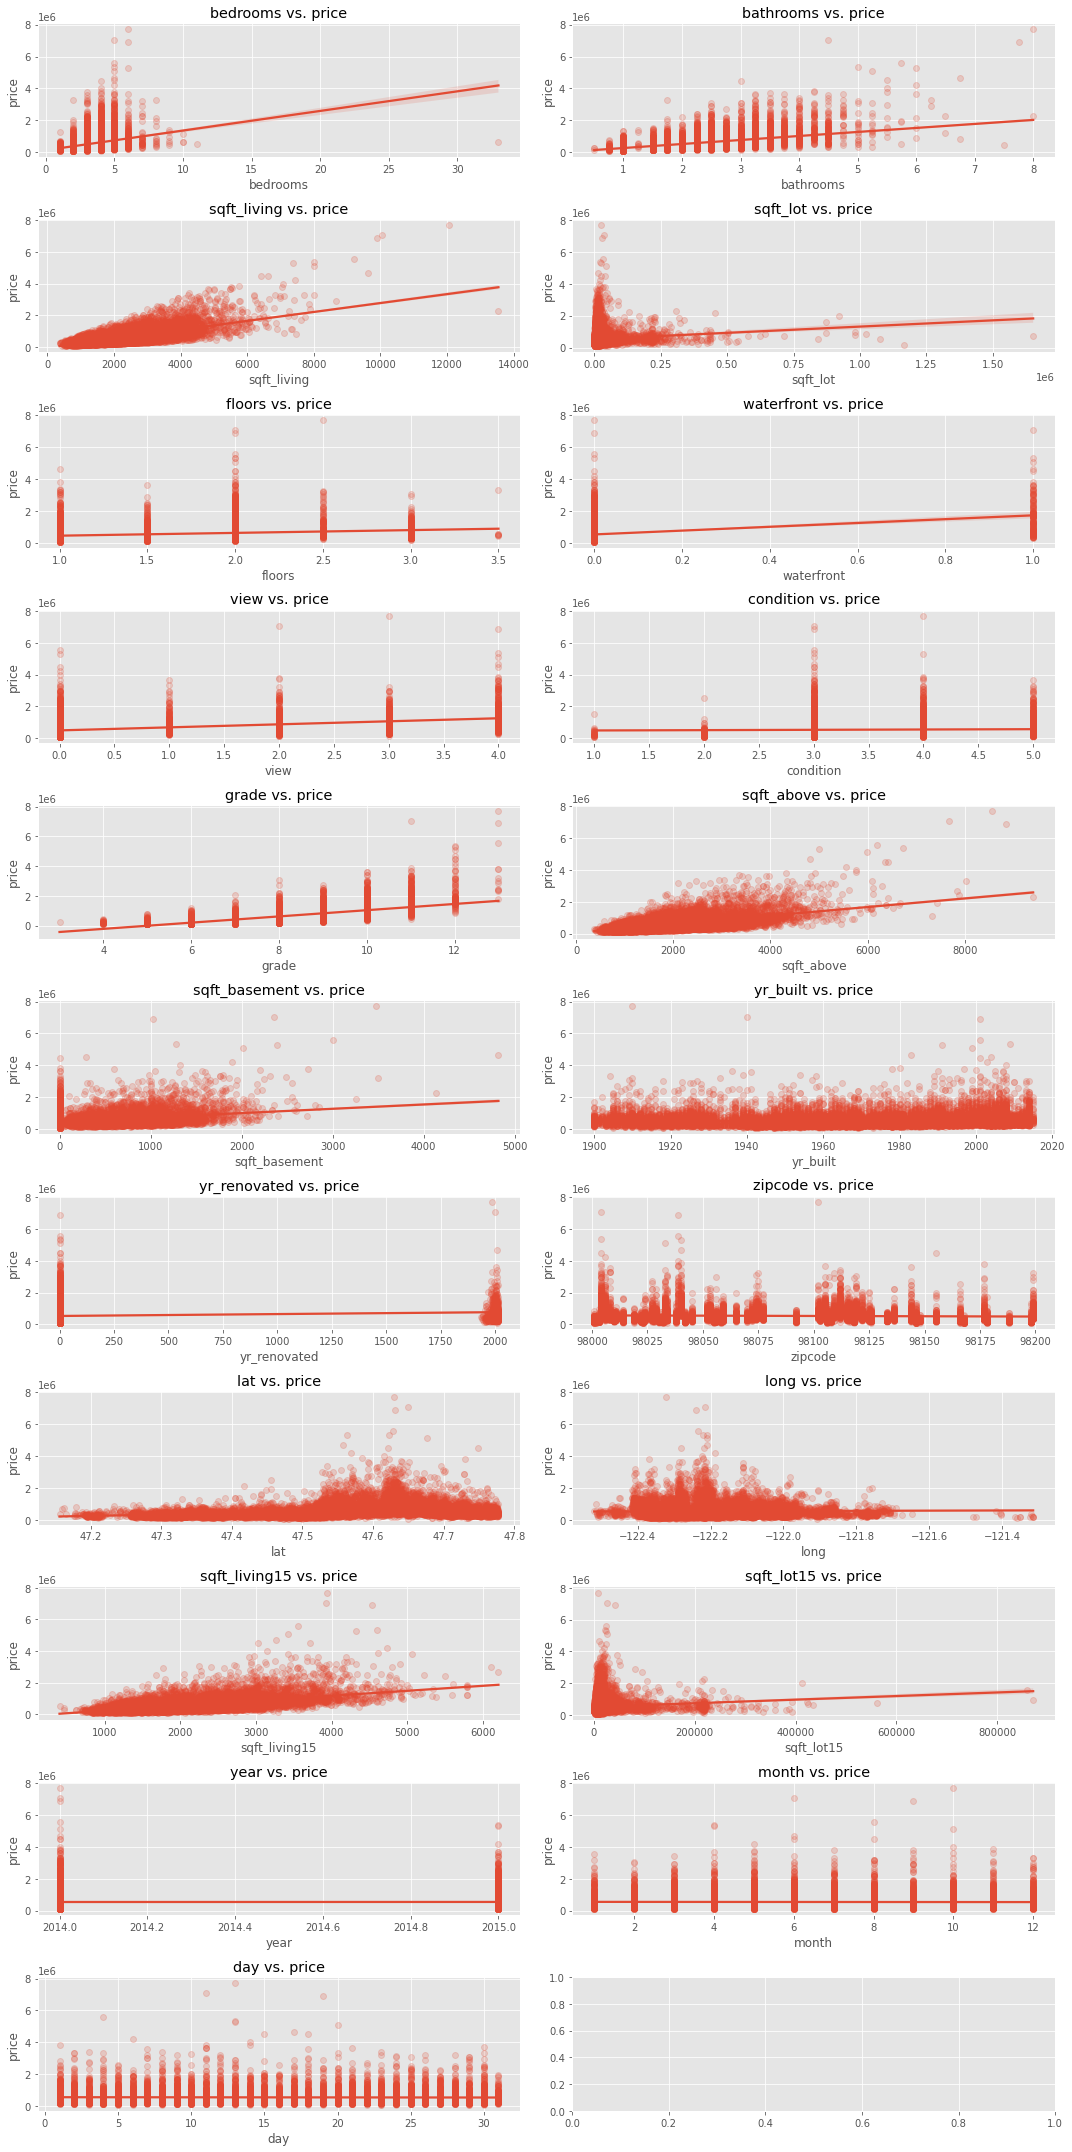

In [18]:
# evaluate relationship between variables and price
preds = clean_df.drop('price', axis=1)
plot_viz(data=clean_df, target='price',
         predictors=preds, nrows=11,
         ncols=2, figsize=(15, 30))

Looking at the variables plotted against price, there are some continuous variables that stand out as not meeting linearity assumptions. These are `yr_built`, `year`, `zipcode`, `lat`, and `long`. 

In [19]:
# drop variables that do not meet linearity requirements
clean_df = clean_df.drop(['yr_built', 'zipcode', 'lat', 'long', 'year'], axis=1)

In [20]:
# breakout categorical columns and plot vs. price
cat_cols = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 
            'grade', 'month', 'day']
cat_vars = clean_df[cat_cols]

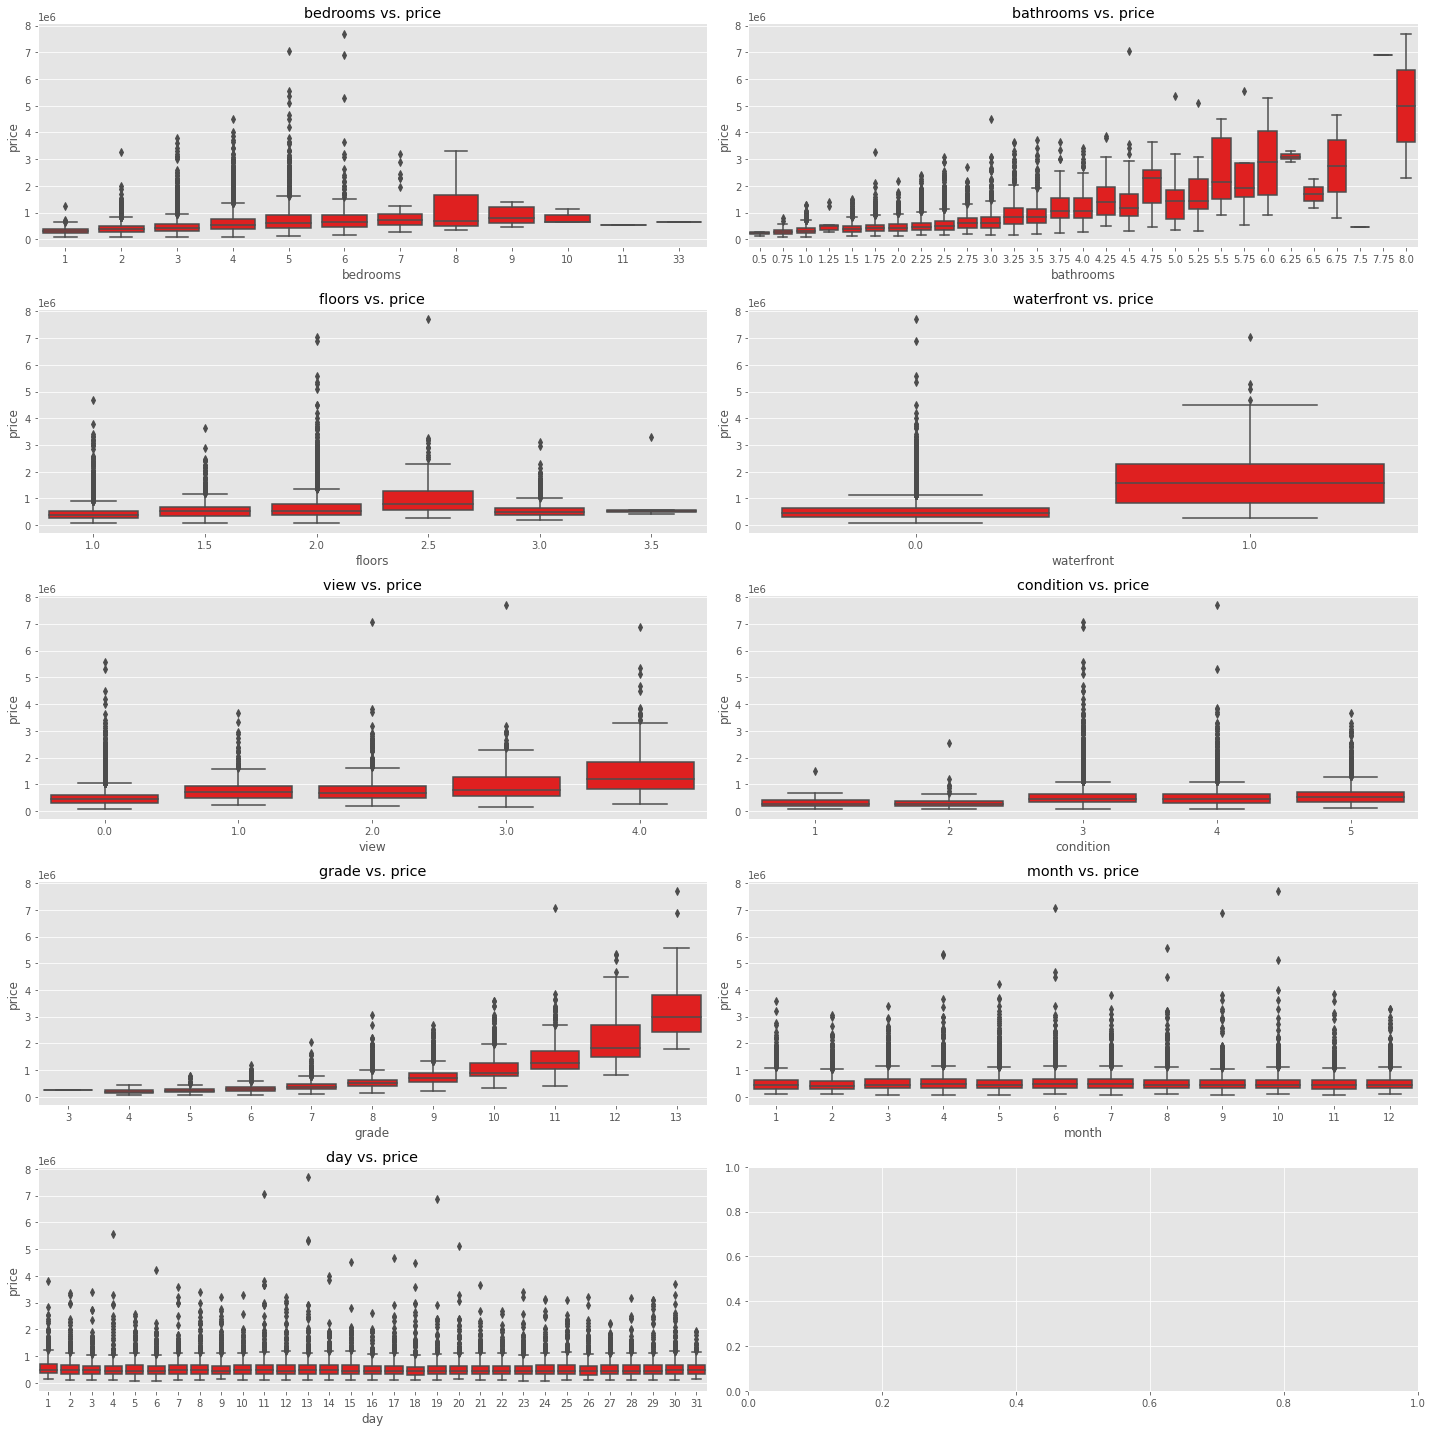

In [23]:
# plot boxplots of all cat columns vs. log_price
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
for ax, feature in zip(axes.flatten(), cat_vars):
    sns.boxplot(x=feature, y='price', data=clean_df, ax=ax, color='red');
    ax.set_title(f'{feature} vs. price')
    
plt.tight_layout()

Looking at boxplots vs. price for all categorical variables, we can see there are a number of outliers present.  Additionally, it is easy to see a number of ordinal related categorical columns.  

Categorical columns with an ordinal relationship to price:
 - bathrooms
 - grade
 
All other categorical columns will be treated as categorical and one-hot encoded

/Users/addingtongraham/opt/anaconda3/envs/keras-env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


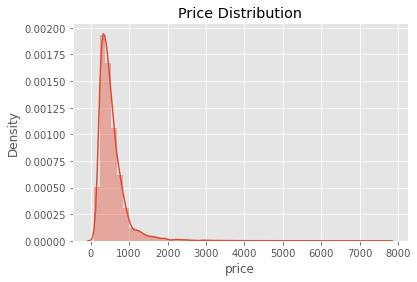

In [24]:
# distribution of target variable
scaled_price = clean_df['price'] / 1000
sns.distplot(scaled_price)
plt.title('Price Distribution')
plt.show()

Looking at a zoomed in distribution of target variable, we can see there is some significant right skew, indicating presence of outliers.  Variable will likely benefit from some sort of transformation - - will evaluate results of baseline prior to any transforming of variables.

### Encode Categorical Columns